In [1]:
# import packages
import numpy as np
import math as math
import pandas as pd
from astropy import units as u
import astropy.constants as const

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

%matplotlib inline

# Solving Kepler's Equation

We assume the two-body reference frame, calculating everything from the rest frame of the star.

[Murray + Correia (2010)](https://arxiv.org/abs/1009.1738)

First, here's our equation for P, from Kepler's 3rd law:
$$ P = \sqrt{\frac{4\pi^{2}a^{3}}{GM_{*}}} $$ 

We predict the RV semi-amplitude using the parameters of our planet, star, and orbit:

$$ K = \left(\frac{2\pi G}{P}\right)^{1/3} \left(\frac{m_p~sin~i}{m_p + m_{star}}\right)^{2/3} \frac{1}{{\sqrt{1 - e^2}}}$$



## Initial (simplifying) conditions
* Number of steps `n` 
* planet starts at periastron at $t = 0$
  * $r_{0} = a(1 - e)$
  * $\theta_{0} = 0$

## Finding $\theta(t)$ and $r(t)$

We compute $r$ and $\theta$ at each time step from 0 to P in `n` steps 
    * If we want to see the behavior over multiple orbits, we scale the time array by `nP`
    
At each time step, we calculate 
$$\Delta\theta = \sqrt{GM_{*}}\frac{(1 + ecos\theta)^{2}}{a(1-e^{2})^{3/2}}\Delta t$$ 

We use the previous step's $~\theta$ to get 
$$\theta_{current} = \theta_{previous} + \Delta\theta$$

We can then solve for $r(\theta)$ 

$$r(\theta_{current}) = \frac{a(1 - e^{2})}{1 +  e cos\theta}$$

    dtheta = ((np.sqrt(const.G * mstar)) * (1 + e * np.cos(current_theta))**2 * ( a * (1 - e**2))**(-3/2) * dt).decompose()


## Calculating RV curve

We use the _vis-viva_ equation to calculate the planet velocity

$$ v_{p, v-v}^2 = GM_{star}\left(\frac{2}{r} - \frac{1}{a}\right)  $$

and use the reduced mass to get the stellar velocity:

$$ v_{star, v-v} = -\frac{m_p}{m_p + m_{star}}v_{p,~v-v} $$

To get the radial component (in the direction of the observer) at a given time $t$ and position $\theta(t)$, we calculate:

$$ v_{star, RV} = v_{star} sin(\theta)~$$


In [2]:
def get_a(mstar, m_p, P):
    """
    Calculate semi-major axis, a, using Kepler's Third law
    
    Inputs:
        mstar, stellar mass
        P, planet period
    Returns:
        a, semi-major axis (AU)
    
    """
    # period from kepler's third law
    # P = np.sqrt(((4*np.pi**2) / (const.G * mstar)) * a**3 )  
    # solve for a:
    
    a = (((const.G * (mstar + m_p) * P**2) / (4*np.pi**2))**(1/3)).to(u.AU)
    return a


In [3]:
def get_incl(b, a, rstar, e, omega):
    """
    For a given impact parameter, b, get the inclination.
    
    Inputs: 
      b, float, impact parameter (< 1, planet transits)
      a, Quantity [AU], semi-major axis
      rstar, Quantity [u.R_sun], planet radius
      e, float, (0 - circular)
      omega, float, (pi/2 - observer at periastron)
    
    Returns:
      incl, float, angle of orbital plane wrt reference plane
    
    """
    #b = ((a * math.cos(incl) / rstar)*((1 - e**2)/(1 + e * math.sin(omega)))).decompose() # assume planet is passing right through the middle of the disk of the star
    incl = math.acos((b / a) * rstar * (1 + e * math.sin(omega)) / (1 - e**2))
    return incl

In [173]:
def set_up_star(star, custom=False):
    """
    Assign stellar, planet, orbit parameters from table row, star.
    
    Inputs:
        star, pandas dataframe row containing target information
        custom, boolean, True to use hard-coded test values for star-planet system
    Returns:
        nothing
        
    Example:
        data_df = pd.read_csv('./mydata.csv')
        set_up_star(data_df.iloc[0])
        print(f"planet mass: {mp}")
    
    """
    

    global koi, mstar, rstar, Pstar, phi_star, mp, rp, P, a, e, omega, b, incl, K
    
    # get params from file
    custom = custom  # sets to custom params
    
    #  KOI 3497, KIC 8424002, Kepler-1512 ???

    if custom:
        koi = 'CUSTOM'
        koimstar, koirstar, koiPstar = 0.5, 0.5, 30.
        koiphistar = 0.*(np.pi/180)
        koimp = 20 # 1.03 # 20
        koirp = 4 # 1.03 # 4
        koiP = 20 # star['Period'] # 20
        
    else:
        arr = star.to_numpy()[0]
        koi = arr[1][3:] #int(star['kepoi_name'].values[0][3:].split(".")[0]) # KOI ID
        koimstar = arr[8]
        koirstar = arr[7]
        koiPstar = arr[14]
        koiphistar = arr[15]
        koimp = arr[5]**(20/11)  # we use a mass-radius approximation
        koirp = arr[5]
        koiP = arr[4]

    print(f"Predicting K for KOI {koi}")
    # star
    mstar = koimstar * u.M_sun  # stellar mass
    rstar = koirstar * u.R_sun  # stellar radius
    Pstar = koiPstar * u.d # stellar rotation period
    phi_star = koiphistar #  # np.pi*0.5 # tilted towards us to be pole on
    print(f"stellar obliquity = {phi_star * (180/np.pi) :.3} deg, stellar rotation period = {Pstar:.3}")
    
    # planet
    mp = koimp * u.M_earth # 1 * u.M_jupiter # planet mass
    rp = koirp * u.R_earth # 1 * u.R_jup # planet radius

    # set orbital parameters

    P = koiP * u.day
    a = get_a(mstar, mp, P)
    e = 0.0  # orbital eccentricity, 0 for now
    omega = np.pi * 0.5
    b = 0. # 0.5
    incl = get_incl(b, a, rstar, e, omega)# np.pi * 0.5  # assume we are observing in-plane, i.e. inclination = 90 deg
    print(f"incl = {incl*(180/np.pi) :.3} deg")

    K = ((2 * math.pi * const.G) / P)**(1/3) * ((mp * math.sin(incl))/(mp + mstar)**(2/3)) / (math.sqrt(1 - e**2))
    print(f"K, semi-amplitude = {K.decompose()}")
    

In [143]:
def plot_orbit_map(thetas, r, rv, K, plt_theta=True):
    # set up figure
    fig = plt.figure(figsize=(12,5),constrained_layout=True)

    # ---------------------------------------------------------------- # 
    # plot path of ellipse
    ax = fig.add_subplot(121, projection='polar')
    ax.plot(thetas, [i.value for i in r], label='orbit') #, s=2)

    # plot observer
    ax.scatter(0,r[0]*1.5, marker='v',s=100, label='observer')

    # add labels
    ax.set_rmax((r.max()*1.25).value)
    #ax.set_rticks([2,4,6,8])  # Fewer radial ticks ([0.5, 1, 1.5, 2])
    ax.set_rlabel_position(-30.5)  # Move radial labels away from plotted line
    ax.set_theta_zero_location("S")
    ax.legend(loc='lower right')
    ax.grid(True)

    # ---------------------------------------------------------------- # 

    # plot RV curve
    ax2 = fig.add_subplot(122)

    plt_theta = True

    # actual radial velocity
    skip = 50
    if plt_theta:
        ax2.scatter(thetas[::skip], rv[::skip], 
                    s=3, c='purple', label=f"RV (every {skip}th point)")
        ax2.set_xlabel(r"$\theta (radians)$")
    else:
        ax2.scatter(t_array[::skip].to(u.day), rv[::skip],
                    s=3, c='purple', label=f"RV (every {skip}th point)")
        #ax2.set_xlabel(r"$time (day)$")
        #ax2.plot(t_array[::skip].to(u.day), rv[::skip],
        #           c='purple', lw=1, alpha=0.7, ls='dashed',label=f"RV, star only")

    # formatting
    ax2.set_title(r"radial velocity, $v_{star}," + f"~K = {K.decompose():.5}$")
    ax2.set_ylabel(r"$V_{star} [m/s]$")

    #ax2.set_xlim(0, 1.01*P.value)
    #ax.set_ylim(-1,1)
    plt.legend()


In [144]:
def kepler_solver(n, P, nP, theta0, r0, noise=0):
    """
    Solve for r, theta at range of times, t
    
    Inputs:
      n, int, number of time steps
      P, Quantity, period (days)
      nP, number of periods
      theta0, initial theta(t=0)
      r0, initial r(t=0) [AU]
      noise, value of scatter in time (ex. 0.01)
      
    Returns:
      arrays of r, theta values and x, y values
    
    """
    
    # debug: track each theta, dtheta
    #current_thetas = np.zeros(len(t_array))
    #dthetas = [0.]
    debug = False

    dt = P / n        # duration of time step
    print(f"dt = {dt.to(u.hr)} for {n} steps")
    t_array = np.linspace(0, P*nP, n*nP).value  # array of time steps from 0 to P
    t_scatter = np.random.normal(0, noise, t_array.shape)
    t_array += t_scatter 
    t_array = np.sort(t_array) * u.d

    # initialize array of longitudes for each time step
    thetas = np.zeros(len(t_array))
    thetas[0] = theta0

    # initialize array of radii
    r = np.zeros(len(t_array)) * u.AU
    r[0] = r0

    # initialize x, y arrays (as defined in Murray+Correia)
    x, y, z = np.zeros((3, len(t_array))) * u.AU
    x[0] = r0 * np.cos(theta0)
    y[0] = r0 * np.sin(theta0)
    z[0] = 0.

    # debug: track each theta, dtheta
    #current_thetas = np.zeros(len(t_array))
    #dthetas = [0.]
    debug = False
    
    # calculate r, theta at each time step
    for i in range(len(t_array)):
        if debug & (i % 1000 == 0):
            print(f"step {i} / {n*nP}")
        
        # get time
        t = t_array[i]
        # get current longitutde
        if debug: print(f"i: {i}, t: {t.decompose()}")
        current_theta = thetas[i] # thetas[np.where(t_array == t)[0][0]]  # current value of theta
        # current_thetas.append(current_theta) # debug only

        # calculate dtheta
        dtheta = ((np.sqrt(const.G * mstar)) * (1 + e * np.cos(current_theta))**2 * ( a * (1 - e**2))**(-3/2) * dt).decompose()
        if debug: 
            print(f"theta + dtheta = {current_theta} + {dtheta} = {current_theta + dtheta}")
        # dthetas.append(dtheta)  # debug only

        # add to get new longitude 
        new_theta = current_theta + dtheta.value
        # save the new theta longitude to the array
        if i+1 == len(t_array):
            pass
        else:
            thetas[i+1] = new_theta

        # because we know theta, we can get the position
        current_r = a * (1 - e**2) / (1 + e * np.cos(current_theta))
        r[i] = current_r
        x[i] = current_r * np.cos(current_theta)  # ellipse major axis for omega = 0
        y[i] = current_r * np.sin(current_theta)  # ellipse minor axis for omega = 0
        z[i] = 0.
        
    return t_array, r, thetas, x, y, z
    

In [231]:
def predict_rm(t_array, r, thetas, x, y, z):
    """
    For a planet orbiting a star, predict the Rossiter-McLaughlin contribution
    
    Inputs: 
        output of kepler_solver()
    Returns:
        t_array, rmrv
    """
    
    global dur 
    
    # calculate radial velocity
    vv = np.sqrt(const.G * mstar * ((2/r) - (1/a)))


    v_star = -(mp/(mp + mstar)) * vv.decompose() #(mp/(mp + mstar) * v_p).decompose()

    # take radial component
    rv = np.sin(thetas) * v_star

    # CHECK THIS WITH AN ADULT: vsini accounts for inclination
    vsini = np.abs(rv * np.sin(incl)).max()
    print(f"calculated vsini = {vsini:.4} (incl = {incl / np.pi :.4}pi)")
    
    print("making RV plot!")
    plot_orbit_map(thetas, r, rv, K, plt_theta=True)
    
    header = f"""Planet: Rp = {rp}, M_p = {mp}
    Star: Rstar = {rstar}, Mstar = {mstar}, P_rot = {Pstar}, phistar = {phi_star}
    Orbit: P = {P.to(u.d)}, a = {a:.6}, b = {b}, i = {incl:.3} omega = {omega:.3}

    time [d], radial velocity [m/s], theta [rad]"""

    # pack up the simulated rv light curve
    #   NB: no synthetic observations are generated for the RV only
    rv_lc = np.array(list(zip(t_array.to(u.day).value, rv.value, thetas)))
    tag = f"KOI_{koi}_phi_{phi_star/np.pi:.3}pi"
    # save to csv
    np.savetxt(f"rv_lcs/{tag}_sim_rv_lc.csv", rv_lc, 
               fmt="%.8f", 
               delimiter=",",
               header=header
              )
    print(f"saved simulated RV curve rv_lcs/{tag}_rv_lc.csv")
    
    # We predict transit duration using Winn (2010), Eq. 14 in Sec. 2.3

    if b < 1:
        dur_circ = ((P / (np.pi * u.rad)) * 
               np.arcsin((rstar / a) * np.sqrt((1 + (rp/rstar))**2 - b**2) / (np.sin(incl)))).to(u.hr)
        correction = np.sqrt(1 - e**2) / (1 + e*np.sin(omega)) # correct for e > 0
        dur = dur_circ * correction
        print(f"Predicted transit duration: {dur:.6}")
        print(f"\t(e = {e}: correction: {correction:.6} x circular orbit duration {dur_circ:.6})")
        print(f"Predicted # pts in transit (dur/dt): {int(np.floor((dur / (P / n)).decompose()))}") # points in transit
    else:
        print(f"b = {b:.5}, no transit")
        
        # find where planet position overlaps with stellar disk

    debug = False 

    x_orbit = np.array([q.value for q in x])  # x-dimension of ellipse (along major axis)
    y_orbit = np.array([q.value for q in y])  # y-dimension of ellipse (along minor axis)


    # extents of stellar disk in y
    left_edge, right_edge = rstar.to(u.AU).value * np.array([-1,1])

    # extents of stellar disk in z 
    bottom_edge, top_edge = rstar.to(u.AU).value * np.array([-1,1])

    # planet orbit position
    x_orbit = np.array([q.value for q in x])  # x-dimension of ellipse (along major axis)
    y_orbit = np.array([q.value for q in y])  # y-dimension of ellipse (along minor axis)
    z_orbit = np.array([q.value for q in z])  # z-dimension of ellipse

    # !-------NOTE: WILL NEED TO CHANGE WHEN b !=0 ----------! 
    # mask y positions when center of planet is within disk of star
    mask_overlap = (y_orbit >= left_edge) & (y_orbit <= right_edge) \
        & (z_orbit <= top_edge) & (z_orbit >= bottom_edge)

    # select y positions when planet is _transiting_
    in_transit = mask_overlap & (x_orbit > 0)
    transit_y = y_orbit[in_transit]
    print(f"{len(transit_y) / nP} points per orbit where planet is in front of star")

    # select y positions before/after transit
    mask_around_transit = (y_orbit >= left_edge*2) & (y_orbit <= right_edge*2) & (x_orbit > 0)
    around_transit_y = y_orbit[mask_around_transit]

    # select y positions when planet is in _eclipse_
    in_eclipse = mask_overlap & (x_orbit < 0) 
    eclipse_y = y_orbit[in_eclipse]
    print(f"{len(eclipse_y) / nP} points per orbit where planet is in eclipse")

    y_b = (b * rstar ).to(u.AU).value
    
    ## now we think about the star as a carton of neapolitan ice cream or 
    #   the French national flag 🇫🇷 and we find how much of each area 
    #    is blocked by the planet

    # x_boundaries = [left_edge, left_edge*(1/3), right_edge*(1/3), right_edge]  

    ## but we can also make the blue/red shift a gradient based on disk position
    #     effectively, making the white zone width=0

    x_boundaries = [left_edge, 0, 0, right_edge]

    testN = 5000000
    pl_r = rp.to(u.AU).value
    st_r = rstar.to(u.AU).value

    # random points on disk of star
    test_x = np.random.random(testN) * (right_edge - left_edge) + left_edge 
    test_y = np.random.random(testN) * (right_edge - left_edge) + left_edge
    test_r = np.sqrt(test_x**2 + test_y**2)

    # select only points on disk of star
    star_mask = test_r < st_r
    star_xtest = test_x[star_mask]
    star_ytest = test_y[star_mask]
    starN = len(star_xtest)

    pl_y = y_b # b = 0, so planet is in the plane of the observer

    # tally up the change in RV due to Ross-McL
    drvs = np.zeros(len(around_transit_y))

    orbit_drvs = np.zeros(len(y_orbit)) # track for whole orbit

    debug = False 

    # of points on star disk, select points on disk of planet as a function of time
    for q in range(len(around_transit_y)): 

        drv = 0.
        # horizontal position relative to (0,0) at center of star disk
        position = around_transit_y[q]

        # index of this position relative to full-orbit array
        yi = [i for i in range(len(y_orbit)) if y_orbit[i] == position][0]
        print(f"position: {position} at index in y_orbit:",yi)

        # is the point in the disk of the planet?
        test_rp = np.sqrt((star_xtest - position)**2 + (star_ytest - pl_y)**2)
        in_planet_mask =  test_rp < pl_r
        pl_xtest = star_xtest[in_planet_mask]
        pl_ytest = star_ytest[in_planet_mask]
        depth_mc = len(pl_xtest) / starN
        print(f"transit depth = {len(pl_xtest)}/{starN} = {depth_mc}")

        # we are seeing the observer-oriented component of vrot, vrot * (y/rstar)
        # we use |y|/rstar as a scaling ratio for the flux 
        obs_vrot = np.cos(phi_star)*np.abs(position * u.AU) / rstar.to(u.au)

        # is the point in the blue part of the star?
        # less blue light -> looks more red-shifted (moving away from viewer)
        blue_mask = (pl_xtest > x_boundaries[0]) & (pl_xtest < x_boundaries[1]) 
        blue_blocked = len(pl_xtest[blue_mask]) / starN
        drv += blue_blocked * obs_vrot
        if debug: print(f"{blue_blocked*100}% blue light blocked")

        # is the point in the white part of the star?
        # no contribution to red/blue shift
        white_mask = (pl_xtest > x_boundaries[1]) & (pl_xtest < x_boundaries[2]) 
        white_blocked = len(pl_xtest[white_mask]) / starN
        if debug: print(f"{white_blocked*100}% white light blocked")

        # is the point in the red part of the star?
        # less red light -> looks more blue-shifted (moving towards viewer)
        red_mask = (pl_xtest > x_boundaries[2]) & (pl_xtest < x_boundaries[3]) 
        red_blocked = len(pl_xtest[red_mask]) / starN
        drv -= red_blocked * obs_vrot
        if debug: print(f"{red_blocked*100}% red light blocked")

        # is the point on the sunspot?
        # TODO

        drvs[q] = drv
        orbit_drvs[yi] = drv

        print(f"sum of red/blue-shifted area fractions at this position: {drv}\n")


    # how much of the star's light is that? 
    #    starlight * (area planet / area star)
    #    if blue area: subtract
    #    if red area: add
    #    if hwite area: nothing

    # vrotational of star 
    vrot = (2 * np.pi * rstar).to(u.m) / (Pstar).to(u.s)
    print(vrot)

    # fraction of light blocked * v_rot  (may not be quite right)
    dvrot = orbit_drvs * vrot 

    # add Ross-McL contribution
    rmrv = rv + dvrot
    
    return rmrv

In [146]:
# get available stars
koi_list = pd.read_csv("./mdwarf_kois_with_vrot.csv")


In [165]:
# pull from KOI list
base_url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?"
table = "cumulative"
columns = "kepid,kepoi_name,kepler_name,koi_disposition,koi_period,koi_prad,koi_steff,koi_srad,koi_smass,koi_sparprov,ra,dec,koi_kepmag"
url = f"{base_url}table={table}&select={columns}&format=csv"
print(f"querying {str(url)}")

exoarchive_koi= pd.read_csv(url)
exoarchive_koi['KID'] = exoarchive_koi['kepid']
exoarchive_koi['Prot'] = np.zeros(len(exoarchive_koi))
exoarchive_koi['phi_star'] = np.zeros(len(exoarchive_koi))

querying https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=kepid,kepoi_name,kepler_name,koi_disposition,koi_period,koi_prad,koi_steff,koi_srad,koi_smass,koi_sparprov,ra,dec,koi_kepmag&format=csv


In [10]:
# # for a list of KOIs
# for i, star in koi_list.iterrows():
#     # set system initial conditions
#     print(star.kepoi_name)
#     set_up_star(star)

#     # add it to the table!
#     koi_list.loc[koi_list['kepoi_name'] == koi, 'K'] = K.decompose().value

# # magnitude - semi-amplitude comparison
# plt.scatter(params_file['koi_kepmag'], params_file['K'])
# plt.xlabel('Kepler magnitude'), plt.ylabel('RV semi-amplitude (m/s)')

# # these babies are wicked faint

In [273]:
star1 = exoarchive_koi[exoarchive_koi['kepoi_name']=='K00961.01'].copy()   # small cool star
star1.Prot = 10.
star1.phi_star = (5/180)*np.pi 

star2 = exoarchive_koi[exoarchive_koi['kepoi_name']=='K00254.01'].copy()   # dynamically hot system
star2.Prot = 10.
star2.phi_star = 0. # (20/180)*np.pi


In [274]:
# KOI - 961
# 3 smol planets

set_up_star(star2)

Predicting K for KOI 254.01
stellar obliquity = 0.0 deg, stellar rotation period = 10.0 d
incl = 90.0 deg
K, semi-amplitude = 49.44390191395699 m / s


In [275]:
# initialize orbit
theta0 = 0.       # initial longitude
r0 = a * (1 - e)  # initial planet position, default: periastron


# initialize kepler solving
n = 5000         # number of steps
nP = 2            # number of periodts the time goes for

### can generate light curves for a given set of parameters

dt = 0.0117851550048 h for 5000 steps
calculated vsini = 49.43 m / s (incl = 0.5pi)
making RV plot!
saved simulated RV curve rv_lcs/KOI_254.01_phi_0.0pi_rv_lc.csv
Predicted transit duration: 1.94884 h
	(e = 0.0: correction: 1.0 x circular orbit duration 1.94884 h)
Predicted # pts in transit (dur/dt): 165
140.0 points per orbit where planet is in front of star
141.5 points per orbit where planet is in eclipse
position: 0.0 at index in y_orbit: 0
transit depth = 115002/3928794 = 0.02927157799569028
sum of red/blue-shifted area fractions at this position: 0.0

position: 3.747363204085035e-05 at index in y_orbit: 1
transit depth = 114881/3928794 = 0.029240779740551427
sum of red/blue-shifted area fractions at this position: -4.235284506020397e-05

position: 7.494720492785999e-05 at index in y_orbit: 2
transit depth = 114853/3928794 = 0.029233652871593675
sum of red/blue-shifted area fractions at this position: -0.00017109394839793867

position: 0.00011242065950728152 at index in y_orbit: 3

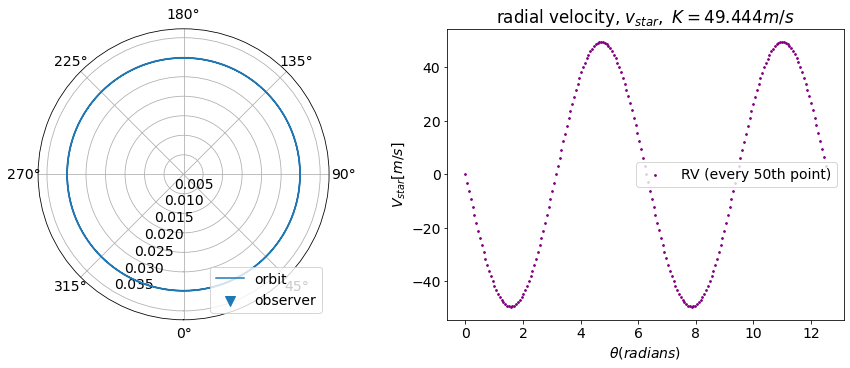

In [276]:
# solve kepler equation
t_array, r, thetas, x, y, z = kepler_solver(n, P, nP, theta0, r0)
rmrv = predict_rm(t_array,r,thetas,x,y,z)

dt = 0.17695427935135136 h for 333 steps
calculated vsini = 49.43 m / s (incl = 0.5pi)
making RV plot!
saved simulated RV curve rv_lcs/KOI_254.01_phi_0.0pi_rv_lc.csv
Predicted transit duration: 1.94884 h
	(e = 0.0: correction: 1.0 x circular orbit duration 1.94884 h)
Predicted # pts in transit (dur/dt): 165
9.0 points per orbit where planet is in front of star
10.0 points per orbit where planet is in eclipse
position: 0.0 at index in y_orbit: 0
transit depth = 115264/3926882 = 0.02935254993656545
sum of red/blue-shifted area fractions at this position: 0.0

position: 0.0005626339223163904 at index in y_orbit: 1
transit depth = 115122/3926882 = 0.02931638893147286
sum of red/blue-shifted area fractions at this position: -0.0062444107222738385

position: 0.0011250676180241037 at index in y_orbit: 2
transit depth = 115458/3926882 = 0.02940195299986096
sum of red/blue-shifted area fractions at this position: -0.012523043146384395

position: 0.001687100931769845 at index in y_orbit: 3
trans

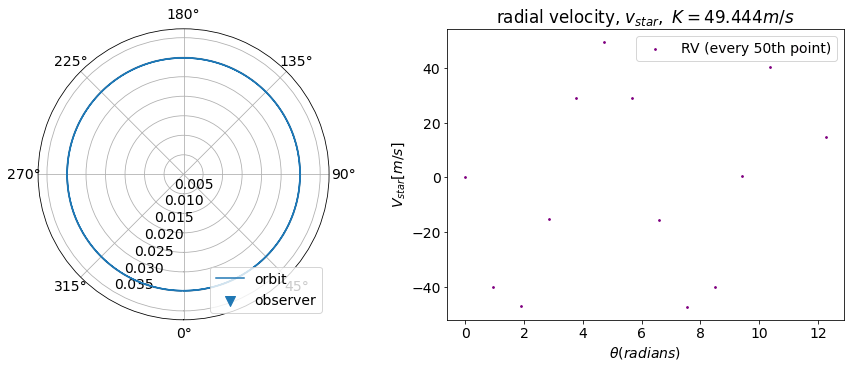

In [277]:
# estimate observed measurements
t_obs, ro, thetaso, xo, yo, zo = kepler_solver(n//15, P, nP, theta0, r0, 0.01)

rmrv_obs = predict_rm(t_obs, ro, thetaso, xo,yo,zo)

In [278]:
## set error parameters (from MAROON-X, Jenn Burt)
sigma_phot = 1.7   # RV photon uncertainty [m/s]
sigma_floor = 0.5  # RV instrument floor [m/s]
sigma_jit = 0.5    # Stellar jitter term [m/s]
sigma_all = np.sqrt(sigma_phot**2 + sigma_floor**2 + sigma_jit**2) # Add all unc. terms in quadrature

# other PRV telescopes
# sigma_all = 0.3

# Now add noise to it according to sigma_all
res = np.random.normal(scale=sigma_all, size=len(rmrv_obs))
rmrv_obs = (rmrv_obs.value + res) * (u.m / u.s)
#plt.hist(res)

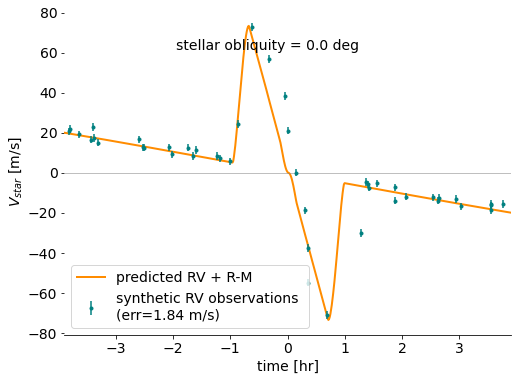

In [279]:
# figure setup
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot()
fs = 14 # font size
plt.rc('font', size=fs)

# actual radial velocity
skip = 1
#ax.scatter(thetas, rv,
#           c='pink', label=f"RV with R-M")
# ax.plot(t_array[::skip].to(u.hr), rv[::skip], 
#         zorder=10,
#         c='black', lw=1, alpha=0.7, ls='dashed',label=f"RV, star only")

# ax.scatter(t_array[::skip].to(u.hr), rv[::skip],
#            c='purple', lw=1, ls='dotted',label=f"RV (every {skip}th point)")


# recall that rmrv = dvrot + rv
ax.plot((t_array - P).to(u.hr), rmrv, 
        #c = 'darkorange', s=10,
        lw=2, c='darkorange',
        label=f"predicted RV + R-M") # (scaled by {scale})")


# plot observed
skip=20
ax.errorbar((t_obs - P).to(u.hr), rmrv_obs, yerr=sigma_all*(u.m/u.s),
            c='teal', fmt='.',label=f"synthetic RV observations \n(err={sigma_all:.3} m/s)"
           )

# plot just the r-m distrubance
# scale = 1
# ax.plot(t_array.to(u.hr), dvrot*scale, 
#         c = 'orange',
#         label=f"R-M (scaled by {scale})")

# plot observations

# Plot interpolated curve
# from scipy.interpolate import interp1d

# #Add some randomization around the observation times, so it's not always at exactly the same minute of the night
# twindow = t_array[(n*nP)//4: 3*(n*nP)//4]
# t_scatter = np.random.normal(0,0.01,twindow.shape) * u.d
# t_obs = np.sort(twindow + t_scatter)
# do the linear interpolation and calculate new y values:
# f_lin = interp1d(t_array, rmrv)
# ynew_lin = f_lin((t_obs.value))
# plt.plot((t_obs).to(u.h), ynew_lin, 
#         #c = 'purple', s=2,
#         lw=2, c='purple',
#         label=f"RV + R-M") # (scaled by {scale})")


# formatting
#ax.set_title(r"radial $V_{star}$ with Rossiter-McLaughlin")
ax.set_xlabel(r"time [hr]")
ax.set_ylabel(r"$V_{star}$ [m/s]")


middle = 1 #P.to(u.hr).value  # 1 to start at 0
window = np.array([-1,1])*2*dur.value
ax.set_xlim(window[0], window[1])
#ax.set_xlim(middle*(1-window), middle*(1+window))  # R-M window

# additional visual markers
# ax.vlines(0.5*dur.value*np.array([-1,1]),ax.get_ylim()[0],ax.get_ylim()[1],
#           color='grey', alpha=0.4 , label=f"dur = {dur:.3}")
ax.hlines(0,window[0],window[1],lw=1,colors='grey',alpha=0.5)

for spine in ax.spines: ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_visible(True)

plt.text(ax.get_xlim()[0]*0.5, ax.get_ylim()[1]*0.75, f"stellar obliquity = {phi_star * (180/np.pi):.3} deg")

#ax.set_facecolor("lightgrey")
#plt.grid(c='white')
plt.legend(loc='lower left')

filename=f"plots/KOI_{koi}_rmrv_lc_b_{b}_phi_{phi_star/np.pi:.3}pi.svg"
plt.savefig(filename, bbox_inches='tight',transparent=True)

In [280]:
# output R-M RV curve
header = f"""Planet: Rp = {rp}, M_p = {mp}
Star: Rstar = {rstar}, Mstar = {mstar}, P_rot = {Pstar} 
Orbit: P = {P.to(u.d)}, dur = {dur:.6}, a = {a:.6}, b = {b}, i = {incl:.3} omega = {omega:.3}

time [d],radial velocity [m/s],theta [rad]"""

# pack up the simulated rv light curve
rv_lc = np.array(list(zip(t_array.to(u.day).value, rmrv.value, thetas)))
# save to csv
filename=f"rv_lcs/KOI_{koi}_sim_rmrv_lc_b_{b}_phi_{phi_star/np.pi:.3}pi.csv"
np.savetxt(filename, rv_lc, 
           fmt="%.8f", 
           delimiter=",",
           header=header)
print(f"saved simulated rv to {filename}")

# pack up the synthetic observations
obs_rv_lc = np.array(list(zip(t_obs.to(u.day).value, rmrv_obs.value, thetaso)))
# save to csv
filename=f"rv_lcs/KOI_{koi}_synthobs_rmrv_lc_b_{b}_phi_{phi_star/np.pi:.3}pi.csv"
np.savetxt(filename, obs_rv_lc, 
           fmt="%.8f", 
           delimiter=",",
           header=header)
print(f"saved synthetic rv observations to {filename}")

saved simulated rv to rv_lcs/KOI_254.01_sim_rmrv_lc_b_0.0_phi_0.0pi.csv
saved synthetic rv observations to rv_lcs/KOI_254.01_synthobs_rmrv_lc_b_0.0_phi_0.0pi.csv


In [264]:
header

'Planet: Rp = 10.6 earthRad, M_p = 73.14632011711237 earthMass\nStar: Rstar = 0.568 solRad, Mstar = 0.587 solMass, P_rot = 10.0 d \nOrbit: P = 2.455240626 d, dur = 1.94884 h, a = 0.0298262 AU, b = 0.0, i = 1.57 omega = 1.57\n\ntime [d],radial velocity [m/s],theta [rad]'

### make star map

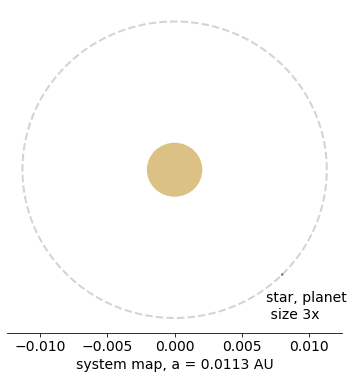

In [223]:
# # ---------------------------------------------------------------- # 
# # plot path of ellipse
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot()

end = n  # plot first round
ax.plot(x[:end], y[:end],'--', 
        color='lightgrey',zorder=1, lw=2,label='orbit')

scale = 3
star = ax.add_artist(plt.Circle((0,0),scale*rstar.to(u.AU).value,fc='darkgoldenrod',
                                 alpha=0.5,label=f'_KOI-{koi}'))

radius = a.value
xp,yp = np.sqrt(0.5)*radius*np.array([1,-1])
planet = ax.add_artist(plt.Circle((xp,yp),scale*rp.to(u.AU).value,
                                   fc='slategrey',label=f'planet'))

# formatting
for spine in ax.spines: ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.set_yticks([])
plt.xlabel(f"system map, a = {a:.3}")
#ax.grid(True)
plt.text(radius*0.6, -radius,f"star, planet \n size {scale}x")


filename=f"plots/KOI_{koi}_map.svg"
plt.savefig(filename, bbox_inches='tight',transparent=True)

# building blocks

These are the cells that are the building blocks of the functions above

In [76]:
# calculate radial velocity
vv = np.sqrt(const.G * mstar * ((2/r) - (1/a)))


v_star = -(mp/(mp + mstar)) * vv.decompose() #(mp/(mp + mstar) * v_p).decompose()

# take radial component
rv = np.sin(thetas) * v_star

# CHECK THIS WITH AN ADULT: vsini accounts for inclination
vsini = np.abs(rv * np.sin(incl)).max()
print(f"calculated vsini = {vsini:.4} (incl = {incl / np.pi :.4}pi)")

calculated vsini = 1.472 m / s (incl = 0.5pi)


In [16]:
header = f"""Planet: Rp = {rp}, M_p = {mp}
Star: Rstar = {rstar}, Mstar = {mstar}, P_rot = {Pstar}, phistar = {phi_star}
Orbit: P = {P.to(u.d)}, a = {a:.6}, b = {b}, i = {incl:.3} omega = {omega:.3}

time [d], radial velocity [m/s], theta [rad]"""

# dur = {dur:.6},

# pack up the rv light curve
rv_lc = np.array(list(zip(t_array.to(u.day).value, rv.value, thetas)))

tag = f"KOI_{koi}_phi_{phi_star/np.pi:.3}pi"

# save to csv
np.savetxt(f"rv_lcs/{tag}_rv_lc.csv", rv_lc, 
           fmt="%.8f", 
           delimiter=",",
           header=header
          )

# Finding when planet transits

Yay! We have an orbit! Now to find when the planet transits.

## Predicting transit time
We can **predict** transit times for an observer positioned at periastron.

We use equation (14) from Winn for a **circular orbit**:

$$ T_{tot} = \frac{P}{\pi}sin^{-1}\left(\frac{R_*}{a}\frac{\sqrt{(1+k)^2 - b^2}}{sin~i}\right) $$

We add a correction term for eccentric orbits.

## Transit time from simulation
We can find **actual** transit times using geometry.

The planet transits when the planet $y$ position is within the disk of the star and the planet $x$ position is in front of the 
star with respect to the observer:

$$ (y_{planet} \le y_{star}) ~\&~ (x_{planet} > 0) $$ 

Likewise, for the planet in eclipse, we simply reverse the requirement for $x_{planet}$: 

$$ (y_{planet} \le y_{star}) ~\&~ (x_{planet} < 0) $$ 

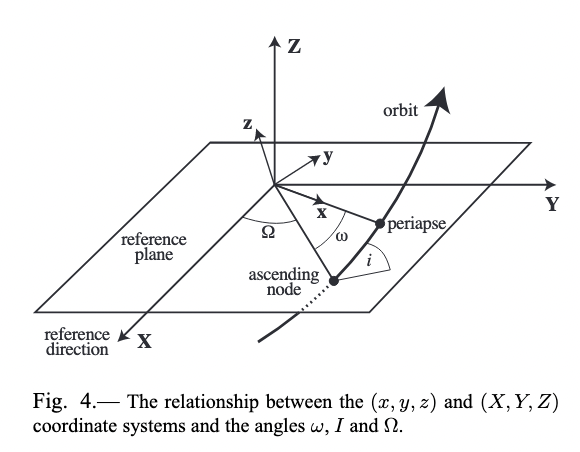

In [17]:
# We predict transit duration using Winn (2010), Eq. 14 in Sec. 2.3

if b < 1:
    dur_circ = ((P / (np.pi * u.rad)) * 
           np.arcsin((rstar / a) * np.sqrt((1 + (rp/rstar))**2 - b**2) / (np.sin(incl)))).to(u.hr)
    correction = np.sqrt(1 - e**2) / (1 + e*np.sin(omega)) # correct for e > 0
    dur = dur_circ * correction
    print(f"Predicted transit duration: {dur:.6}")
    print(f"\t(e = {e}: correction: {correction:.6} x circular orbit duration {dur_circ:.6})")
    print(f"Predicted # pts in transit (dur/dt): {int(np.floor((dur / (P / n)).decompose()))}") # points in transit
else:
    print(f"b = {b:.5}, no transit")


Predicted transit duration: 0.59046 h
	(e = 0.0: correction: 1.0 x circular orbit duration 0.59046 h)
Predicted # pts in transit (dur/dt): 101


In [18]:
# find where planet position overlaps with stellar disk

debug = False 

x_orbit = np.array([q.value for q in x])  # x-dimension of ellipse (along major axis)
y_orbit = np.array([q.value for q in y])  # y-dimension of ellipse (along minor axis)


# extents of stellar disk in y
left_edge, right_edge = rstar.to(u.AU).value * np.array([-1,1])

# extents of stellar disk in z 
bottom_edge, top_edge = rstar.to(u.AU).value * np.array([-1,1])

# planet orbit position
x_orbit = np.array([q.value for q in x])  # x-dimension of ellipse (along major axis)
y_orbit = np.array([q.value for q in y])  # y-dimension of ellipse (along minor axis)
z_orbit = np.array([q.value for q in z])  # z-dimension of ellipse

# !-------NOTE: WILL NEED TO CHANGE WHEN b !=0 ----------! 
# mask y positions when center of planet is within disk of star
mask_overlap = (y_orbit >= left_edge) & (y_orbit <= right_edge) \
    & (z_orbit <= top_edge) & (z_orbit >= bottom_edge)

# select y positions when planet is _transiting_
in_transit = mask_overlap & (x_orbit > 0)
transit_y = y_orbit[in_transit]
print(f"{len(transit_y) / nP} points per orbit where planet is in front of star")

# select y positions before/after transit
mask_around_transit = (y_orbit >= left_edge*2) & (y_orbit <= right_edge*2) & (x_orbit > 0)
around_transit_y = y_orbit[mask_around_transit]

# select y positions when planet is in _eclipse_
in_eclipse = mask_overlap & (x_orbit < 0) 
eclipse_y = y_orbit[in_eclipse]
print(f"{len(eclipse_y) / nP} points per orbit where planet is in eclipse")



97.0 points per orbit where planet is in front of star
97.0 points per orbit where planet is in eclipse


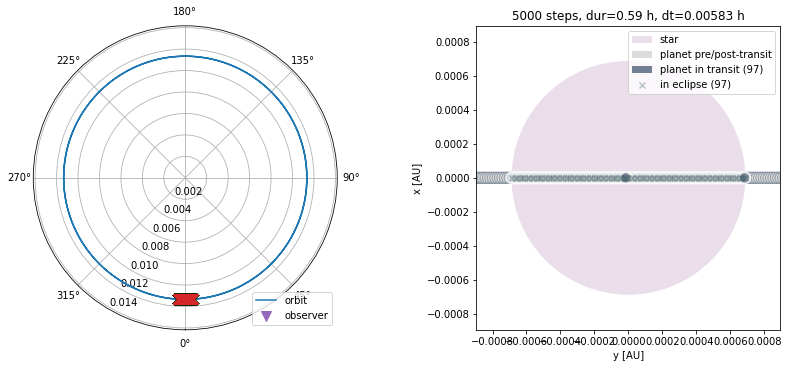

In [27]:
## we then plot the planet relative to the orbit of the star

## for |b| > 0, we assume transit happens at b

# set up figure
fig = plt.figure(figsize=(12,5),constrained_layout=True)

# ---------------------------------------------------------------- # 
# plot path of ellipse
ax = fig.add_subplot(121, projection='polar')
ax.plot(thetas, [i.value for i in r], label='orbit') #, s=2)

# plot points in transit
for i in np.arange(len(transit_y)):
    ax.scatter(thetas[in_transit], r[in_transit], marker='x',s=100, zorder=10)
    # ax.arrow(overlap_theta[i], overlap_r[i], overlap_theta[i]*2, 100, width=1e-5,color='grey')

# plot observer
ax.scatter(0,r[0]*1.5, marker='v',s=100, label='observer')


# add labels
ax.set_rmax((r.max()*1.25).value)
#ax.set_rticks([2,4,6,8])  # Fewer radial ticks ([0.5, 1, 1.5, 2])
ax.set_rlabel_position(-30.5)  # Move radial labels away from plotted line
ax.set_theta_zero_location("S")
ax.legend(loc='lower right')
ax.grid(True)

# ---------------------------------------------------------------- # 
# plot on face of star
ax2 = fig.add_subplot(122, aspect='equal')
# ax2.axis([-2, 2, -2, 2])
# ax2.axis("equal")
star = ax2.add_artist(plt.Circle((0,0),rstar.to(u.AU).value,fc='thistle',
                                 alpha=0.5,label='star'))

# for legend reasons only

y_b = (b * rstar ).to(u.AU).value

_planet = ax2.add_artist(plt.Circle((0,y_b),rp.to(u.AU).value,
                                    fc='gainsboro',label='planet pre/post-transit'))
planet = ax2.add_artist(plt.Circle((0,y_b),rp.to(u.AU).value,
                                   fc='slategrey',label=f'planet in transit ({int(len(transit_y)/nP)})'))

# add points before/after transit
for i in np.arange(int(len(around_transit_y)/nP)):
    ax2.add_artist(plt.Circle((around_transit_y[i],y_b),rp.to(u.AU).value,
                              ec='slategrey',fc='gainsboro', alpha=0.7))
# add points in transit
for i in np.arange(int(len(transit_y)/nP)):
    ax2.add_artist(plt.Circle((transit_y[i],y_b),rp.to(u.AU).value,
                            ec='white',lw=2, fc='slategrey',alpha=0.8))
# add points in eclipse
n_to_plot = int(len(eclipse_y)/nP)
ax2.scatter(eclipse_y[:n_to_plot], np.zeros(n_to_plot) - y_b,
            alpha=0.3, color='darkslategrey', marker='x', label=f'in eclipse ({n_to_plot})')

# formatting 
ax2.set_xlabel("y [AU]")
ax2.set_ylabel("x [AU]")
ax2.set_title(f"{n} steps, dur={dur.to(u.hr):.3}, dt={(P/n).to(u.hr):.3}")

window = 1.3 # 1.3
ax2.set_xlim(left_edge*window,right_edge*window)
ax2.set_ylim(left_edge*window,right_edge*window)

ax2.legend(loc='upper right')


# Calculating Rossiter-McLaughlin contribution

Reference: [Gaudi and Winn, 2007](https://www.astronomy.ohio-state.edu/gaudi.1/rmeffect.pdf)

Fantastic! We now have a transiting planet. 

Next, we track two quantities as a function of time:
* how much starlight the planet blocks
* whether that starlight is red- or blue-shifted

To get a rough idea, we use a Monte Carlo dartboard approach.

1. **All points** We start with `testN` test points in a square with side length $2R_{star}$.

2. **Points in star disk** We find `starN`, the number of points with position (x,y) within in the radius of the star:  
    $$ condition(in~star) =  \sqrt{x^2 + y^2} \lt R_{star} $$
   
   We work with this number, `starN` = `testN[condition(in star)] / testN` for the rest of the exercise.  
   
3. **Points in planet disk** For a given position of the planet in front of the disk, we get the number of points within the radius of the planet:
    condition
    $$ condition(in~planet) = \sqrt{((x - x_p(t))^2 + (y - y_p(t))^2)} \lt R_{planet} $$ 
    
    We get the transit depth:
    $$ d = \frac{N_{star}(condition(in~planet))}{N_{star}}  $$
    
4. **Points in blue/white/red region** For the points in the star disk and in the planet disk, we get the fraction of light blocked when the planet moves through the blue or red or white region.

    $$ condition(in~blue) = x_{blue,~L} < x < x_{blue,~R}  $$ 
    
    $$ F_{in~blue} = \frac{ N_{p}(condition(in~blue))}{N_{star}} $$   
    
    (same for red and white)
 
5. **Fraction of total** We add up the fractional change to the nominal transit depth $d$ measured at time $t$:
    $$ F_{tot} = F_{in~blue} - F_{in~red} $$ 
    
    Note we do not change $F_{tot}$ for transit positions over the "white" part of the star because there is no radial velocity contribution. 
    
6. We plot $F_{tot}$ as a function of time. 



In [34]:
## now we think about the star as a carton of neapolitan ice cream or 
#   the French national flag 🇫🇷 and we find how much of each area 
#    is blocked by the planet

# x_boundaries = [left_edge, left_edge*(1/3), right_edge*(1/3), right_edge]  

## but we can also make the blue/red shift a gradient based on disk position
#     effectively, making the white zone width=0

x_boundaries = [left_edge, 0, 0, right_edge]

testN = 5000000
pl_r = rp.to(u.AU).value
st_r = rstar.to(u.AU).value

# random points on disk of star
test_x = np.random.random(testN) * (right_edge - left_edge) + left_edge 
test_y = np.random.random(testN) * (right_edge - left_edge) + left_edge
test_r = np.sqrt(test_x**2 + test_y**2)

# select only points on disk of star
star_mask = test_r < st_r
star_xtest = test_x[star_mask]
star_ytest = test_y[star_mask]
starN = len(star_xtest)

pl_y = y_b # b = 0, so planet is in the plane of the observer

# tally up the change in RV due to Ross-McL
drvs = np.zeros(len(around_transit_y))

orbit_drvs = np.zeros(len(y_orbit)) # track for whole orbit

debug = False 

# of points on star disk, select points on disk of planet as a function of time
for q in range(len(around_transit_y)): 
    
    drv = 0.
    # horizontal position relative to (0,0) at center of star disk
    position = around_transit_y[q]

    # index of this position relative to full-orbit array
    yi = [i for i in range(len(y_orbit)) if y_orbit[i] == position][0]
    print(f"position: {position} at index in y_orbit:",yi)
    
    # is the point in the disk of the planet?
    test_rp = np.sqrt((star_xtest - position)**2 + (star_ytest - pl_y)**2)
    in_planet_mask =  test_rp < pl_r
    pl_xtest = star_xtest[in_planet_mask]
    pl_ytest = star_ytest[in_planet_mask]
    depth_mc = len(pl_xtest) / starN
    print(f"transit depth = {len(pl_xtest)}/{starN} = {depth_mc}")
    
    # we are seeing the observer-oriented component of vrot, vrot * (y/rstar)
    # we use |y|/rstar as a scaling ratio for the flux 
    obs_vrot = np.cos(phi_star)*np.abs(position * u.AU) / rstar.to(u.au)
    
    # is the point in the blue part of the star?
    # less blue light -> looks more red-shifted (moving away from viewer)
    blue_mask = (pl_xtest > x_boundaries[0]) & (pl_xtest < x_boundaries[1]) 
    blue_blocked = len(pl_xtest[blue_mask]) / starN
    drv += blue_blocked * obs_vrot
    if debug: print(f"{blue_blocked*100}% blue light blocked")
    
    # is the point in the white part of the star?
    # no contribution to red/blue shift
    white_mask = (pl_xtest > x_boundaries[1]) & (pl_xtest < x_boundaries[2]) 
    white_blocked = len(pl_xtest[white_mask]) / starN
    if debug: print(f"{white_blocked*100}% white light blocked")
    
    # is the point in the red part of the star?
    # less red light -> looks more blue-shifted (moving towards viewer)
    red_mask = (pl_xtest > x_boundaries[2]) & (pl_xtest < x_boundaries[3]) 
    red_blocked = len(pl_xtest[red_mask]) / starN
    drv -= red_blocked * obs_vrot
    if debug: print(f"{red_blocked*100}% red light blocked")
        
    # is the point on the sunspot?
    # TODO
    
    drvs[q] = drv
    orbit_drvs[yi] = drv
    
    print(f"sum of red/blue-shifted area fractions at this position: {drv}\n")
    

# how much of the star's light is that? 
#    starlight * (area planet / area star)
#    if blue area: subtract
#    if red area: add
#    if hwite area: nothing



position: 0.0 at index in y_orbit: 0
transit depth = 9212/3926649 = 0.0023460207418590255
sum of red/blue-shifted area fractions at this position: 0.0

position: 1.4248159259201563e-05 at index in y_orbit: 1
transit depth = 9219/3926649 = 0.0023478034323923527
sum of red/blue-shifted area fractions at this position: -2.5574646940790275e-05

position: 2.8496296018940696e-05 at index in y_orbit: 2
transit depth = 9237/3926649 = 0.0023523874937637665
sum of red/blue-shifted area fractions at this position: -9.098472653465963e-05

position: 4.274438777979049e-05 at index in y_orbit: 3
transit depth = 9213/3926649 = 0.002346275411935215
sum of red/blue-shifted area fractions at this position: -0.0001457134979424845

position: 5.699241204239512e-05 at index in y_orbit: 4
transit depth = 9237/3926649 = 0.0023523874937637665
sum of red/blue-shifted area fractions at this position: -0.00019479041945663652

position: 7.124034630750531e-05 at index in y_orbit: 5
transit depth = 9223/3926649 = 0.0

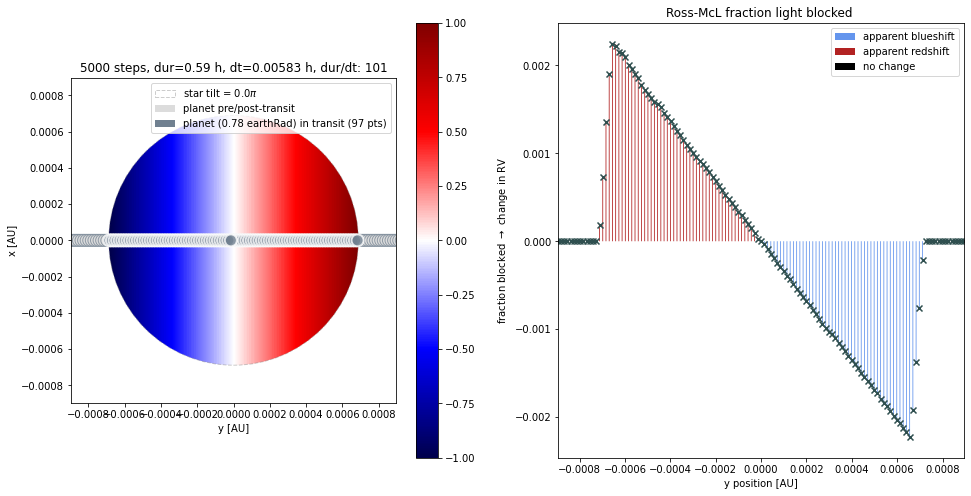

In [35]:
fig = plt.figure(figsize=(16,8))

# track R-M on star disk
ax = fig.add_subplot(121, aspect='equal')

"""
# back when I was thinking about planets as squares
for i in np.arange(len(transit_y)):
    ax.add_patch(Rectangle((transit_y[i]-rp.to(u.AU).value,-rp.to(u.AU).value),
                           2*rp.to(u.AU).value,2*rp.to(u.AU).value,
                           color='slategrey',lw=2,alpha=0.8,zorder=9))
ax.add_patch(Rectangle((transit_y[0]-rp.to(u.AU).value,-rp.to(u.AU).value),
                       2*rp.to(u.AU).value,2*rp.to(u.AU).value,
                       color='pink',lw=2,alpha=0.8,zorder=9))
"""

dt = P / n

# rotating regions of (circular) star
# monotonically-increasing color bar
xmap, ymap, rval = 0, 0, rstar.to(u.AU).value
img = ax.imshow(np.linspace(np.round(-math.cos(phi_star),6),np.round(math.cos(phi_star),6),100).reshape(1,-1), 
                cmap='seismic',
                extent=[xmap - rval, xmap + rval, ymap - rval, ymap + rval ], origin='lower')
circle = plt.Circle((0,0),rval, alpha=0.5,   # fc='thistle',
                          label=r'star ({} $R_\odot$)'.format(rstar.value), transform=ax.transData)
img.set_clip_path(circle)
plt.colorbar(img)
# add outline
ax.add_artist(plt.Circle((0,0),rval, linestyle='--', alpha=0.4, ec='grey',fc='None', 
                         label=f'star tilt = {phi_star/np.pi:.3}'+r'$\pi$'))

# sunspot! 
# spot = ax.add_artist(plt.Circle((ss_x.value, ss_y.value), ss_r.value, color='black'))

# for legend reasons only
_planet = ax.add_artist(plt.Circle((0,y_b),rp.to(u.AU).value,
                                    fc='gainsboro',label='planet pre/post-transit'))
planet = ax.add_artist(plt.Circle((0,y_b),rp.to(u.AU).value,
                                   fc='slategrey',
                                  label=f'planet ({rp}) in transit ({int(len(transit_y)/nP)} pts)'))


# add planet positions before/after transit
for i in np.arange(int(len(around_transit_y)/nP)):
    ax.add_artist(plt.Circle((around_transit_y[i], y_b),rp.to(u.AU).value,
                              ec='slategrey',fc='gainsboro', alpha=0.7))
# add planet positions in transit
for i in np.arange(int(len(transit_y)/nP)):
    ax.add_artist(plt.Circle((transit_y[i],y_b),rp.to(u.AU).value,
                            ec='white',lw=2, fc='slategrey',alpha=0.8))

# formatting 
ax.set_xlabel("y [AU]")
ax.set_ylabel("x [AU]")
ax.set_title(f"{n} steps, dur={dur.to(u.hr):.3}, dt={(P/n).to(u.hr):.3}, dur/dt: {int(np.floor((dur / dt).decompose()))}")

ax.set_xlim(left_edge*1.3,right_edge*1.3)
ax.set_ylim(left_edge*1.3,right_edge*1.3)

plt.legend(loc='upper right')

##### plot the contribution to RV from Rossiter-McLaughlin
ax2 = fig.add_subplot(122)

# for legend purposes only
plt.arrow(0,0,0,0,width=0,facecolor='cornflowerblue', edgecolor='none',
         label="apparent blueshift")
plt.arrow(0,0,0,0,width=0,facecolor='firebrick', edgecolor='none',
         label="apparent redshift")
plt.arrow(0,0,0,0,width=0,facecolor='black', edgecolor='none',
         label="no change")

width = np.diff(around_transit_y)[0]*0.25
n_to_plot = int(len(drvs) / nP)
# loop through positions we examined
for q in range(n_to_plot):
    dy=np.round(drvs[q],6)
    if drvs[q] > 0: # apparent red-shift
        plt.arrow(x=around_transit_y[q], y=0, dx=0, dy=dy, 
                  width=width,facecolor='firebrick', edgecolor='none')
    elif drvs[q] < 0: # apparent blue-shift
        plt.arrow(x=around_transit_y[q], y=0, dx=0, dy=dy, 
                  width=width, facecolor='cornflowerblue', edgecolor='none')
    else:
        plt.arrow(x=around_transit_y[q], y=0, dx=0, dy=dy, 
                  width=width,facecolor='black', edgecolor='none')


ax2.scatter(around_transit_y[:n_to_plot],np.round(drvs[:n_to_plot],6),marker='x',fc='darkslategrey') # x, y, u, v

# formatting 
ax2.set_xlim(left_edge*1.3,right_edge*1.3)
#ylims = tuple(0.5*rv.max().value*np.array([-1,1])) # (drvs.min()*1.3,drvs.max()*1.3)
#ax2.set_ylim(ylims)
ax2.set_xlabel("y position [AU]")
ax2.set_ylabel(r"fraction blocked $\rightarrow$ change in RV")
ax2.set_title(r"Ross-McL fraction light blocked ")
plt.legend()

plt.savefig("areaBlockedRatio_up_down_RM.png")

# vrot star ~ 1.6 km/s

# Calculating RV and R-M contribution

We've already calculated the radial velocity due to the planet tugging on the star.

We would like to take into account the contribution to the radial (measured) velocity from the rotation of the star.

$$ v_{radial,~tot} = v_{planet \rightarrow star} sin\theta + v_{rot} sin\theta $$

We assume a constant $v_{rot}$ at the equator of the star. For $i$ points on the star disk, 

$$ \sum_i v_{rot} = \sum_i v_{rot} sin(\theta_i) \\
= \int_{\pi/2}^{\pi/2} v_{rot} sin\theta d\theta \\
= 0 $$


so it follows that rotational velocity should make zero contribution to radial velocity.


_However_ when part of the star is blocked by the planet, the apparent rotational velocity either increases or decreases depending on whether the planet is blocking a blue-shifted or red-shifted part of the star.

We recall $F_{tot}$, the sum of the contributions of apparent redshift and blueshift from the planet blocking part of of the star.

$$  v_{tot}(t) = v_{planet \rightarrow star} sin\theta + F_{tot} v_{rot} sin\theta_i $$ 


In [36]:
# vrotational of star 
vrot = (2 * np.pi * rstar).to(u.m) / (Pstar).to(u.s)
print(vrot)

# fraction of light blocked * v_rot  (may not be quite right)
dvrot = orbit_drvs * vrot 

# add Ross-McL contribution
rmrv = rv + dvrot


748.7724290443473 m / s


# Comparing different cases

We can now toggle and tune at our leisure

In [240]:
# comparing b=0, b=0.5 cases (star normal), b=0 star pole-on case
rv_flat = pd.read_csv('./rmrv_lc_b_0.0.csv', header=4, names=['time [d]', 'rv [m/s]', 'theta [rad]'])
rv_above = pd.read_csv('./rmrv_lc_b_0.5.csv', header=4, names=['time [d]', 'rv [m/s]', 'theta [rad]'])
rv_pole = pd.read_csv('./rmrv_lc_b_0.0_phi_0.5pi.csv', header=4, names=['time [d]', 'rv [m/s]', 'theta [rad]'])

Text(0, 0.5, 'RV (m/s)')

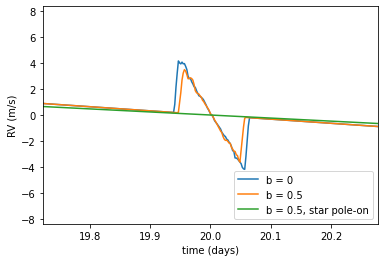

In [241]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(rv_flat['time [d]'], rv_flat['rv [m/s]'], label="b = 0")
ax.plot(rv_above['time [d]'], rv_above['rv [m/s]'], label="b = 0.5")
ax.plot(rv_pole['time [d]'], rv_pole['rv [m/s]'], label="b = 0.5, star pole-on")
ax.legend(loc='lower right')

middle = P.value  # 1 to start at 0
window = 2*(dur.to(u.d))/P
ax.set_xlim(middle*(1-window), middle*(1+window))

ax.set_xlabel('time (days)')
ax.set_ylabel('RV (m/s)')


In [242]:
# comparing star tilts
rm_notilt = pd.read_csv('./KOI_5228_rmrv_lc_b_0.0_phi_0.0pi.csv', header=4, names=['time [d]', 'rv [m/s]', 'theta [rad]'])
rm_45tilt = pd.read_csv('./KOI_5228_rmrv_lc_b_0.0_phi_0.25pi.csv', header=4, names=['time [d]', 'rv [m/s]', 'theta [rad]'])


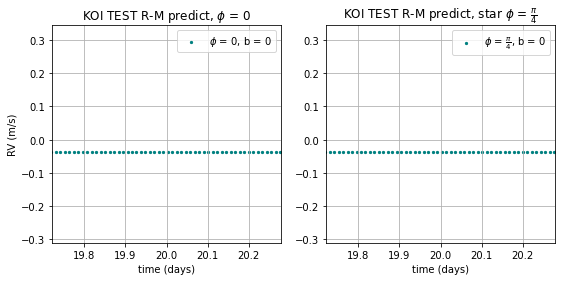

In [243]:
fig = plt.figure(figsize=(9,4))

ax = fig.add_subplot(121)
ax.scatter(rm_notilt['time [d]'], rm_notilt['rv [m/s]'], 
           s=5,c='teal',label=r"$\phi$ = 0, b = 0")
ax.legend(loc='upper right')
ax.set_title(f"KOI {koi} R-M predict, "+ r"$\phi$ = 0")
plt.grid()

ax2 = fig.add_subplot(122)
ax2.scatter(rm_45tilt['time [d]'], rm_45tilt['rv [m/s]'], 
         s=5,c='teal',label=r"$\phi$ = $\frac{\pi}{4}$, b = 0")
ax2.legend(loc='upper right')
ax2.set_title(f"KOI {koi} R-M predict, "+ r"star $\phi$ = $\frac{\pi}{4}$")


middle = P.value  # 1 to start at 0
window = 2*(dur.to(u.d))/P
ax.set_xlim(middle*(1-window), middle*(1+window))
ax2.set_xlim(middle*(1-window), middle*(1+window))
ax2.set_ylim(ax.get_ylim())

ax.set_xlabel('time (days)')
ax.set_ylabel('RV (m/s)')
ax2.set_xlabel('time (days)')

plt.grid()

plt.savefig(f'KOI_{koi}_rmrv_compare_starphi.png')